In [1]:
%load_ext autoreload
%autoreload 2

Dependencies

In [2]:
import pathlib as pb

# Environment
ROOT_PATH = pb.Path('..')
DATA_DIR_PATH = ROOT_PATH / 'data'
CACHE_DIR_PATH = ROOT_PATH / '.cache'
TRANSFORMERS_CACHE_DIR_PATH = CACHE_DIR_PATH / 'transformers'
DATASETS_CACHE_DIR_PATH = CACHE_DIR_PATH / 'datasets'
TEST_DATA_FILE = DATA_DIR_PATH / 'test_data.csv'
TRAIN_DATA_FILE = DATA_DIR_PATH / 'train_data.csv'
SUBMISSIONS_DIR_PATH = ROOT_PATH / 'submissions'

In [3]:
import os

os.environ['TRANSFORMERS_CACHE'] = str(TRANSFORMERS_CACHE_DIR_PATH)
os.environ['HF_DATASETS_CACHE'] = str(DATASETS_CACHE_DIR_PATH)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
import torchdata
import torchtext
from torch import Tensor
from torch import nn
from torch import optim
from torch.utils.data import Subset, DataLoader, Dataset
from torch import backends
import typing
import pathlib as pb
import os
import gc
from typing import List, Tuple, Dict, Set, Callable, Any
import random
import numpy as np
import pandas as pd
import platform
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score

/home/invokariman/Projects/git/nitro-lang-processing-2/.cache/pypoetry/virtualenvs/nitro-lang-processing-2-mFR9zZTH-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from utils import get_available_device, read_data, silence_warnings
from preprocess import BERTPreprocessor, MT5Preprocessor
from data import SexismDataset
from models import Args, Output, BertFlatClassModel, MT5FlatClassModel
from train import evaluate, train

Environment Setup

In [6]:
# Use available GPU
DEVICE: torch.device = get_available_device()

# Deterministic experiments
SEED = 61
random.seed(SEED)
np.random.seed(SEED)
np.random.RandomState(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

# Adjust package settings
silence_warnings()

Dataset & Preprocessing

In [7]:
# Load raw dataset
train_data_raw, test_data_raw = read_data(DATA_DIR_PATH)

# Initialize custom pretraiend preprocessor
preprocessor = MT5Preprocessor()

# Create and preprocess the datasets
train_dataset = SexismDataset(train_data_raw, preprocessor)
test_dataset = SexismDataset(test_data_raw, preprocessor)

Model Setup

In [8]:
# Keep the training setup separately
args = Args()
model_factory: Callable[[], nn.Module] = lambda: torch.compile(MT5FlatClassModel()).to(DEVICE)
optim_factory: Callable[..., optim.Optimizer] = lambda params: optim.AdamW(params, lr=args.learning_rate, weight_decay=args.weight_decay)
loss_fn = nn.CrossEntropyLoss(weight=train_dataset.weights.to(DEVICE))

HyperParameter Tuning using K-Fold Cross-Validation

In [9]:
# Inspired from: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for i, (train_idx, valid_idx) in enumerate(kf.split(train_dataset, train_dataset.classes)):
    print('K-FOLD: {}'.format(i))
    
    # Reinitialize the model
    model: nn.Module = model_factory()
    optimizer: optim.Optimizer = optim_factory(model.parameters())

    # Split the data
    train_subset = Subset(train_dataset, train_idx)
    valid_subset = Subset(train_dataset, valid_idx)

    # Create the dataloaders
    train_loader = DataLoader(train_subset, args.batch_size)
    valid_loader = DataLoader(train_subset, args.batch_size)

    # --- Validation ---
    def validation_pass() -> None:
        # --- Validation ---
        valid_output: Output = evaluate(
            model=model,
            loss_fn=loss_fn,
            data_loader=valid_loader,
            with_labels=True,
            class_to_label=train_dataset.class_to_label,
            device=DEVICE
        )
        print('Validation - Loss: {}, Accuracy: {}'.format(valid_output.loss_mean, valid_output.accy_mean))

    # --- Training ---
    train_output: Output = train(
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        data_loader=train_loader,
        class_to_label=train_dataset.class_to_label,
        args=args,
        device=DEVICE,
        valid_callback=validation_pass,
    )
    print('Last Epoch - Loss: {}, Accuracy: {}'.format(train_output.loss_mean, train_output.accy_mean))
    break

K-FOLD: 0


You are using a model of type t5 to instantiate a model of type mt5. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at dumitrescustefan/mt5-base-romanian were not used when initializing MT5Model: ['lm_head.weight']
- This IS expected if you are initializing MT5Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MT5Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-03-26 01:27:52,758] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Training on the Whole Dataset

In [ ]:
# Reinitialize the model
model: nn.Module = model_factory()
optimizer: optim.Optimizer = optim_factory(model.parameters())

# Create the dataloaders
train_loader = DataLoader(train_dataset, args.batch_size, shuffle=True)

# --- Training ---
train_output: Output = train(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    data_loader=train_loader,
    class_to_label=train_dataset.class_to_label,
    args=args,
    device=DEVICE,
)
print('Last Epoch - Loss: {}, Accuracy: {}'.format(train_output.loss_mean, train_output.accy_mean))


Prediction

In [ ]:
test_loader: DataLoader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
test_output: Output = evaluate(
    model=model,
    loss_fn=loss_fn,
    data_loader=test_loader,
    with_labels=False,
    class_to_label=train_dataset.class_to_label,
    device=DEVICE
)

<Axes: >

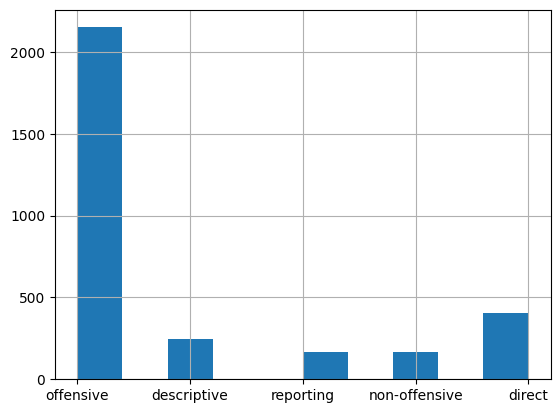

In [ ]:
output: pd.DataFrame = pd.DataFrame({ 'Label': pd.Series(data=test_output.predictions_as_text) })
output = output.reset_index()
output = output.rename(columns={ 'index': 'Id' })
output.to_csv(SUBMISSIONS_DIR_PATH / 'submission_9.csv', index=False)
output['Label'].hist()

In [ ]:
# Free memory
# del model
# gc.collect()
# torch.cuda.empty_cache()